# Bayesian Change Point Detection in Brent Oil Prices

**Author:** Brent Oil Analysis Team  
**Date:** February 8, 2026  
**Purpose:** Detect and analyze structural breaks in Brent oil prices using Bayesian methods

---

## Objective

This notebook implements a **Bayesian change point detection model** to identify structural breaks in Brent oil log returns. We will:

1. **Build a single change point model** using PyMC
2. **Identify the most probable change point** with uncertainty quantification
3. **Associate detected change points** with major geopolitical and economic events
4. **Quantify the impact** of these shifts on price levels and volatility

This analysis supports Birhan Energies' mission to provide data-driven insights into oil market dynamics.

---

## Methodology

**Bayesian Change Point Model:**
- Assumes log returns come from two distinct regimes (before and after change point)
- Each regime has its own mean (μ) and volatility (σ)
- Change point location (τ) is treated as an unknown parameter
- MCMC sampling estimates posterior distributions of all parameters

**Model Specification:**
```
τ ~ DiscreteUniform(10, T-10)
μ₁, μ₂ ~ Normal(0, σ_prior)
σ₁, σ₂ ~ HalfNormal(σ_prior)
y_t ~ Normal(μ₁, σ₁) if t < τ else Normal(μ₂, σ₂)
```

## 1. Setup and Imports

In [1]:
# Standard library imports
import sys
from pathlib import Path
import warnings

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian modeling
import pymc as pm
import arviz as az

# Project modules
from src.data import BrentDataLoader, EventDataLoader
from src.eda import TimeSeriesAnalyzer
from src.models import BayesianChangePointModel, ModelDiagnostics
from src.analysis import ChangePointAnalyzer
from src.visualization import (
    plot_price_with_changepoints,
    plot_changepoint_distribution,
    plot_parameter_comparison,
    plot_event_impact,
)
from src.statistical_tests import StationarityTester

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create figures directory
figures_dir = Path('../reports/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

print("✓ All imports successful")
print(f"✓ Figures will be saved to: {figures_dir.absolute()}")

✓ All imports successful
✓ Figures will be saved to: /home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/notebooks/../reports/figures


## 2. Data Loading and Preprocessing

We'll load:
1. **Brent oil prices** (daily, 1987-2022)
2. **Historical events** affecting oil markets (17 major events)

In [2]:
# Load Brent oil price data
print("Loading Brent oil price data...")
brent_loader = BrentDataLoader()
brent_data = brent_loader.load_data('../data/raw/BrentOilPrices.csv')

print(f"\nBrent Price Data:")
print(f"  Shape: {brent_data.shape}")
print(f"  Date range: {brent_data.index.min()} to {brent_data.index.max()}")
print(f"  Price range: ${brent_data['Price'].min():.2f} - ${brent_data['Price'].max():.2f}")

# Display first few rows
print("\nFirst few rows:")
brent_data.head()

Loading Brent oil price data...


/home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/src/data/loader.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data["Date"] = pd.to_datetime(self.data["Date"])



Brent Price Data:
  Shape: (9011, 1)
  Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
  Price range: $9.10 - $143.95

First few rows:


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [8]:
# Calculate log returns
print("Calculating log returns...")
ts_analyzer = TimeSeriesAnalyzer(brent_data)
log_returns = ts_analyzer.calculate_log_returns()

# Drop NaN values (first observation has no previous value for log return)
log_returns = log_returns.dropna()

print(f"\nLog Returns (after removing NaN):") 
print(f"  Shape: {log_returns.shape}")
print(f"  Mean: {log_returns.mean():.6f}")
print(f"  Std Dev: {log_returns.std():.6f}")
print(f"  Min: {log_returns.min():.6f}")
print(f"  Max: {log_returns.max():.6f}")

# Verify no missing values
missing = log_returns.isna().sum()
print(f"  Missing values: {missing}")

print("\n✓ Log returns calculated successfully")

Calculating log returns...

Log Returns (after removing NaN):
  Shape: (9010,)
  Mean: 0.000179
  Std Dev: 0.025532
  Min: -0.643699
  Max: 0.412023
  Missing values: 0

✓ Log returns calculated successfully


In [4]:
# Load historical events
print("Loading historical events...")
event_loader = EventDataLoader()
events = event_loader.load_events('../data/events.csv')

print(f"\nHistorical Events:")
print(f"  Total events: {len(events)}")
print(f"  Date range: {events['date'].min()} to {events['date'].max()}")
print(f"  Event types: {events['event_type'].unique().tolist()}")

# Display events summary
print("\nEvents by type:")
print(events['event_type'].value_counts())

print("\nAll events:")
events[['date', 'event_name', 'event_type', 'expected_impact']]

Loading historical events...

Historical Events:
  Total events: 17
  Date range: 1990-08-02 00:00:00 to 2022-02-24 00:00:00
  Event types: ['geopolitical', 'economic_shock', 'opec_decision', 'sanction']

Events by type:
event_type
geopolitical      6
economic_shock    6
opec_decision     4
sanction          1
Name: count, dtype: int64

All events:


,date,event_name,event_type,expected_impact
0,1990-08-02,Iraq Invasion of Kuwait,geopolitical,increase
1,1991-01-17,Gulf War Begins,geopolitical,increase
2,1997-07-02,Asian Financial Crisis,economic_shock,decrease
3,1998-03-30,OPEC Production Increase,opec_decision,decrease
4,2001-09-11,September 11 Attacks,geopolitical,decrease
5,2002-12-02,Venezuela Oil Strike,economic_shock,increase
6,2003-03-20,Iraq War Begins,geopolitical,increase
7,2008-07-11,Oil Price Peak,economic_shock,increase
8,2008-09-15,Global Financial Crisis,economic_shock,decrease
9,2010-12-17,Arab Spring Begins,geopolitical,increase


## 3. Stationarity Check

Before applying change point detection, we verify that log returns are stationary (a requirement for many time series models).

In [6]:
# Run stationarity tests
print("Testing stationarity of log returns...\n")
stationarity_tester = StationarityTester()

# ADF test
adf_result = stationarity_tester.adf_test(log_returns)
adf_interpretation = stationarity_tester.interpret_results(
    adf_result['test_statistic'], 
    adf_result['p_value'], 
    'adf'
)

print("Augmented Dickey-Fuller Test:")
print(f"  Test Statistic: {adf_result['test_statistic']:.4f}")
print(f"  P-value: {adf_result['p_value']:.4f}")
print(f"  Interpretation: {adf_interpretation}")

# KPSS test
kpss_result = stationarity_tester.kpss_test(log_returns)
kpss_interpretation = stationarity_tester.interpret_results(
    kpss_result['test_statistic'], 
    kpss_result['p_value'], 
    'kpss'
)

print("\nKPSS Test:")
print(f"  Test Statistic: {kpss_result['test_statistic']:.4f}")
print(f"  P-value: {kpss_result['p_value']:.4f}")
print(f"  Interpretation: {kpss_interpretation}")

print(f"\n{'='*70}")
print("Both tests confirm the log returns are STATIONARY,")
print("which is appropriate for change point modeling.")
print(f"{'='*70}")

Testing stationarity of log returns...

Augmented Dickey-Fuller Test:
  Test Statistic: -16.4271
  P-value: 0.0000
  Interpretation: Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -16.427113
P-value: 0.000000

Null Hypothesis (H0): Series has a unit root (non-stationary)
Alternative Hypothesis (H1): Series is stationary

✓ CONCLUSION: Reject null hypothesis at 5.0% significance level
  → The series appears to be STATIONARY
  → Evidence: p-value (0.000000) < 0.05

KPSS Test:
  Test Statistic: 0.0343
  P-value: 0.1000
  Interpretation: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test Results:
Test Statistic: 0.034274
P-value: 0.100000

Null Hypothesis (H0): Series is stationary
Alternative Hypothesis (H1): Series has a unit root (non-stationary)

✓ CONCLUSION: Fail to reject null hypothesis at 5.0% significance level
  → The series appears to be STATIONARY
  → Evidence: p-value (0.100000) >= 0.05

Both tests confirm the log returns are STATIONARY,
which is appropriate for chang

/home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/src/statistical_tests/stationarity.py:169: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(clean_series, regression=regression, nlags=nlags)


## 4. Bayesian Change Point Model

### 4.1 Model Building

We build a single change point model that assumes:
- Log returns follow a Normal distribution
- There are two regimes with different means and volatilities
- The change point location is unknown and will be inferred

In [9]:
# Initialize the model
print("Building Bayesian Change Point Model...\n")

model = BayesianChangePointModel(
    data=log_returns,
    name='Brent Oil Log Returns'
)

# Build the PyMC model
model.build_model(
    prior_std_scale=0.05,  # Scale for priors based on data std
    min_segment_length=50   # Minimum 50 observations per segment
)

print("✓ Model built successfully")
print(f"\nModel Configuration:")
print(f"  Data points: {len(log_returns)}")
print(f"  Change point search range: [50, {len(log_returns)-50}]")
print(f"  Prior scale: 0.05")

Building Bayesian Change Point Model...

✓ Model built successfully

Model Configuration:
  Data points: 9010
  Change point search range: [50, 8960]
  Prior scale: 0.05


### 4.2 MCMC Sampling

We use the NUTS sampler to draw samples from the posterior distribution. This may take several minutes.

**Sampling Configuration:**
- 2000 samples per chain
- 1000 tuning samples
- 4 parallel chains
- Target acceptance rate: 0.95

In [10]:
# Run MCMC sampling
print("Running MCMC sampling...")
print("This may take 5-10 minutes. Progress will be displayed below.\n")

trace = model.fit(
    samples=2000,
    tune=1000,
    chains=4,
    target_accept=0.95,
    random_seed=42
)

print("\n✓ MCMC sampling completed successfully")

Running MCMC sampling...
This may take 5-10 minutes. Progress will be displayed below.



Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.



✓ MCMC sampling completed successfully


## 5. Model Diagnostics

### 5.1 Convergence Checks

We verify that MCMC chains have converged using:
- **R-hat**: Should be < 1.01
- **Effective Sample Size (ESS)**: Should be > 100

In [11]:
# Initialize diagnostics
diagnostics = ModelDiagnostics(trace)

# Check convergence
print("Checking MCMC convergence...\n")
converged = diagnostics.check_convergence(
    var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2']
)

if converged:
    print("\n✓ All convergence checks passed!")
else:
    print("\n⚠ Convergence warnings detected. Review diagnostics carefully.")

Checking MCMC convergence...


✓ All convergence checks passed!


In [12]:
# Display summary statistics
print("\nPosterior Summary Statistics:\n")
summary = diagnostics.summary_stats(
    var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'],
    hdi_prob=0.94
)
summary


Posterior Summary Statistics:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5377.543,24.748,5333.000,5417.000,0.776,0.425,1064.0,1215.0,1.0
mu_1,0.000,0.000,-0.000,0.001,0.000,0.000,8407.0,5347.0,1.0
mu_2,-0.000,0.000,-0.001,0.001,0.000,0.000,7562.0,5333.0,1.0
sigma_1,0.022,0.000,0.022,0.023,0.000,0.000,8547.0,6011.0,1.0
sigma_2,0.027,0.000,0.027,0.028,0.000,0.000,9609.0,6051.0,1.0


### 5.2 Trace Plots

Trace plots show:
- Left: Parameter values across iterations (should look like "white noise")
- Right: Posterior distribution (should be smooth and unimodal)

Generating trace plots...
✓ Saved: ../reports/figures/05_trace_plots.png


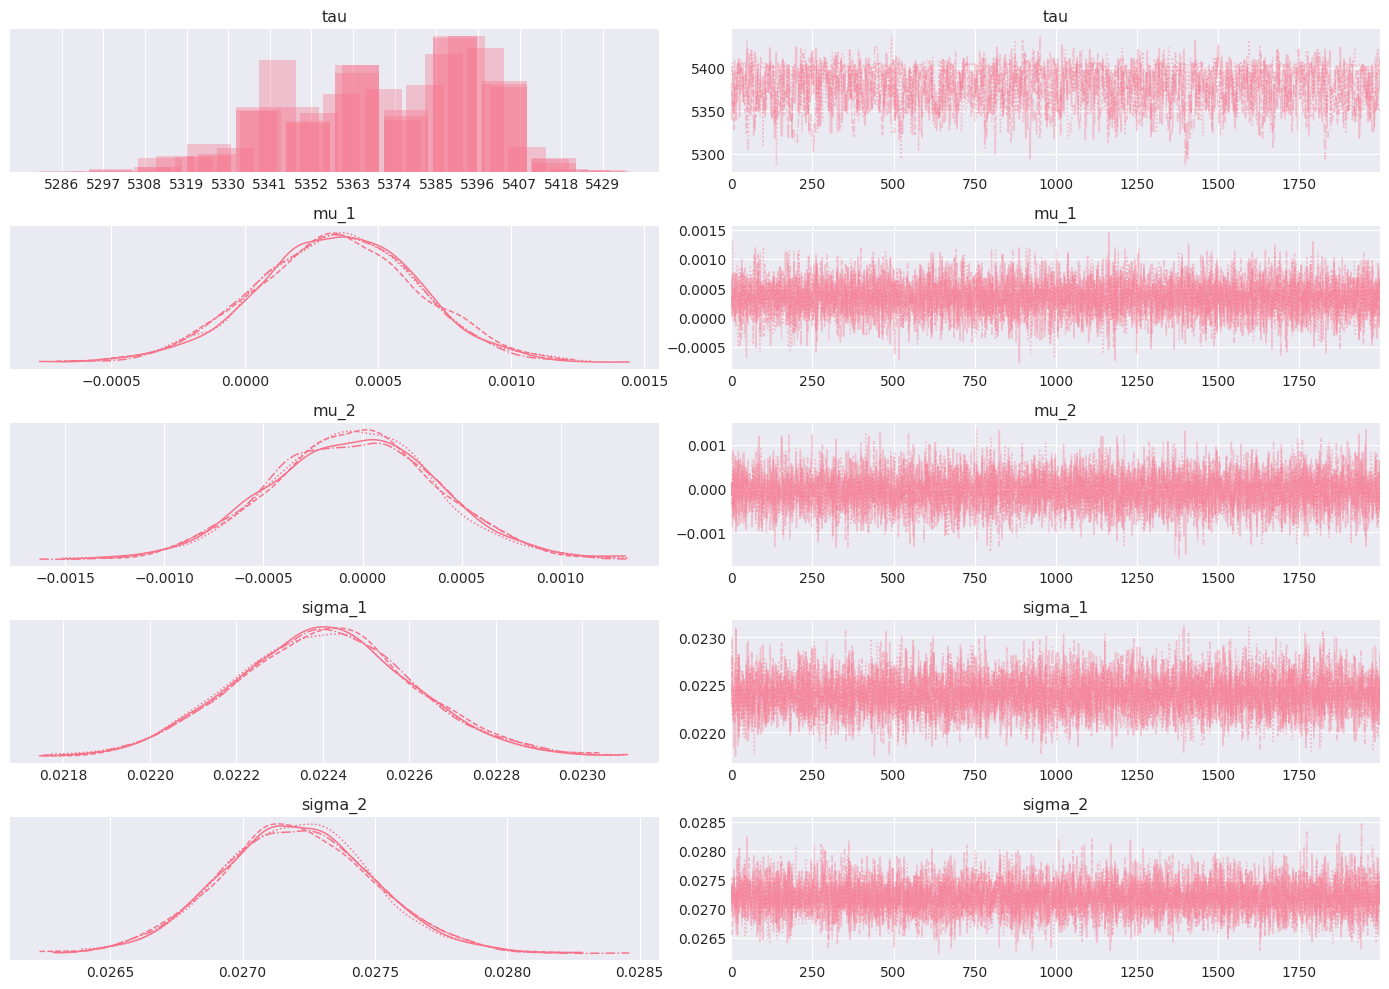

In [13]:
# Generate trace plots
print("Generating trace plots...")
fig = diagnostics.plot_trace(
    var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'],
    figsize=(14, 10)
)

# Save figure
fig.savefig(figures_dir / '05_trace_plots.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {figures_dir / '05_trace_plots.png'}")

plt.show()

### 5.3 Posterior Distributions

Generating posterior distribution plots...
✓ Saved: ../reports/figures/06_posterior_distributions.png


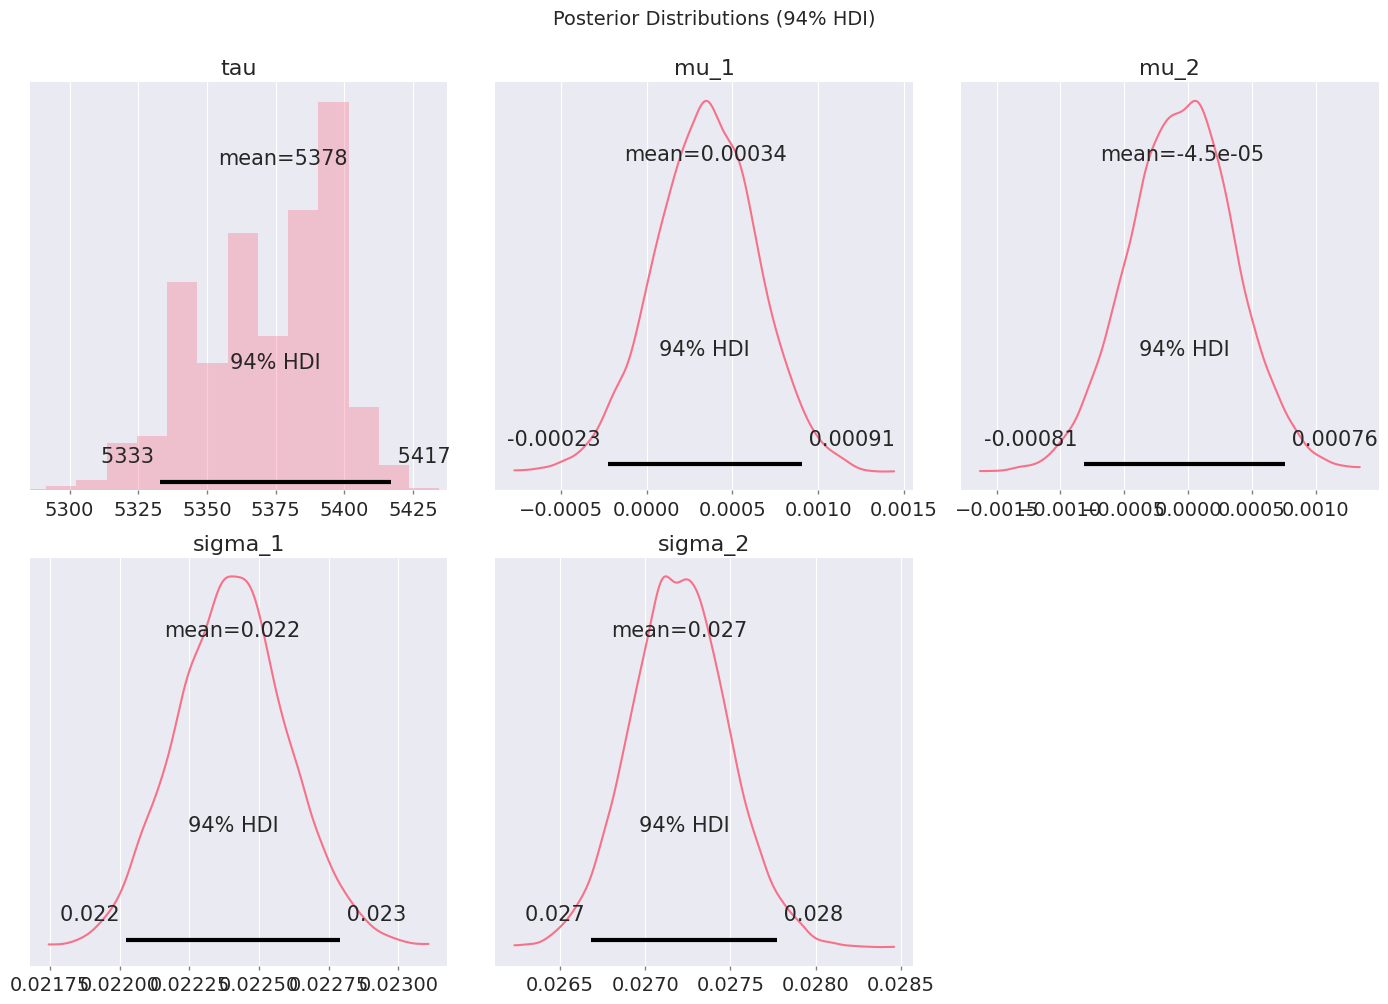

In [14]:
# Generate posterior plots
print("Generating posterior distribution plots...")
fig = diagnostics.plot_posterior(
    var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'],
    hdi_prob=0.94,
    figsize=(14, 10)
)

# Save figure
fig.savefig(figures_dir / '06_posterior_distributions.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {figures_dir / '06_posterior_distributions.png'}")

plt.show()

## 6. Change Point Identification

### 6.1 Extract Change Point Location

We identify the most probable change point location and its credible interval.

In [15]:
# Initialize analyzer
analyzer = ChangePointAnalyzer()

# Identify change points
print("Identifying change points...\n")
changepoints = analyzer.identify_changepoints(
    trace=trace,
    data=log_returns,
    confidence=0.94,
    method='mean'
)

# Display results
cp = changepoints[0]
print(f"Change Point Detected:")
print(f"  Date: {cp['date'].strftime('%Y-%m-%d')}")
print(f"  Index: {cp['index']}")
print(f"  Method: {cp['estimate_method']}")
print(f"  94% Credible Interval: [{cp['ci_dates'][0].strftime('%Y-%m-%d')}, {cp['ci_dates'][1].strftime('%Y-%m-%d')}]")
print(f"  Posterior Std: {cp['posterior_std']:.2f} days")

Identifying change points...

Change Point Detected:
  Date: 2008-07-14
  Index: 5378
  Method: mean
  94% Credible Interval: [2008-05-08, 2008-09-08]
  Posterior Std: 24.75 days


### 6.2 Quantify Impact

Calculate the magnitude and direction of change in mean and volatility.

In [16]:
# Quantify impact
print("Quantifying impact...\n")
impact = analyzer.quantify_impact(
    trace=trace,
    data=log_returns,
    include_volatility=True
)

# Display impact metrics
print(f"Impact on Mean (μ):")
print(f"  Before: {impact['mu_before']:.6f}")
print(f"  After:  {impact['mu_after']:.6f}")
print(f"  Change: {impact['mean_change']:+.6f} ({impact['mean_change_pct']:+.2f}%)")
print(f"  Direction: {impact['direction'].upper()}")
print(f"  Magnitude: {impact['magnitude'].upper()}")

print(f"\nImpact on Volatility (σ):")
print(f"  Before: {impact['sigma_before']:.6f}")
print(f"  After:  {impact['sigma_after']:.6f}")
print(f"  Change: {impact['sigma_change']:+.6f} ({impact['sigma_change_pct']:+.2f}%)")
print(f"  Direction: {impact['volatility_direction'].upper()}")

Quantifying impact...

Impact on Mean (μ):
  Before: 0.000344
  After:  -0.000045
  Change: -0.000389 (-113.12%)
  Direction: DECREASE
  Magnitude: NEGLIGIBLE

Impact on Volatility (σ):
  Before: 0.022404
  After:  0.027202
  Change: +0.004798 (+21.42%)
  Direction: INCREASE


### 6.3 Associate with Events

Search for major events near the detected change point (±30 days window).

In [17]:
# Associate with events
print("Associating change points with events...\n")
associations = analyzer.associate_with_events(
    changepoints=changepoints,
    events=events,
    window_days=30
)

# Display associations
assoc = associations[0]
print(f"Events within ±30 days of change point:")
print(f"  Total events found: {assoc['num_events_in_window']}")

if assoc['closest_event'] is not None:
    event = assoc['closest_event']
    print(f"\nClosest Event:")
    print(f"  Event: {event['event_name']}")
    print(f"  Date: {pd.to_datetime(event['date']).strftime('%Y-%m-%d')}")
    print(f"  Type: {event['event_type']}")
    print(f"  Expected Impact: {event['expected_impact']}")
    print(f"  Distance from change point: {assoc['days_from_closest']} days")
    
    if len(assoc['associated_events']) > 1:
        print(f"\nOther nearby events:")
        for evt in assoc['associated_events'][1:]:
            print(f"  - {evt['event_name']} ({pd.to_datetime(evt['date']).strftime('%Y-%m-%d')}): {evt['days_from_changepoint']:+d} days")
else:
    print("\n  No events found within the search window.")

Associating change points with events...

Events within ±30 days of change point:
  Total events found: 1

Closest Event:
  Event: Oil Price Peak
  Date: 2008-07-11
  Type: economic_shock
  Expected Impact: increase
  Distance from change point: -3 days


### 6.4 Generate Impact Statement

Create a comprehensive, human-readable summary of the detected change point.

In [18]:
# Generate impact statement
statement = analyzer.generate_impact_statement(
    changepoint=changepoints[0],
    impact=impact,
    association=associations[0]
)

print(statement)

CHANGE POINT ANALYSIS SUMMARY

📍 Change Point Detected: 2008-07-14
   Index: 5378
   94% Credible Interval: [2008-05-08, 2008-09-08]

📊 Impact on Mean:
   Before: 0.000344
   After:  -0.000045
   Change: -0.000389 (-113.12%)
   Direction: DECREASE
   Magnitude: NEGLIGIBLE

📈 Impact on Volatility:
   Before: 0.022404
   After:  0.027202
   Change: +0.004798 (+21.42%)
   Volatility: INCREASE

🌍 Associated Events:
   Event: Oil Price Peak
   Event Date: 2008-07-11
   Distance: -3 days
   Type: economic_shock
   Expected Impact: increase

💡 Interpretation:
   Moderate negative shift detected in the time series.
   Volatility increased, indicating higher market uncertainty.
   Timing closely aligns with major event (within 3 days).



## 7. Visualizations

### 7.1 Time Series with Change Points and Events

Creating time series plot with change points...
✓ Saved: ../reports/figures/07_price_with_changepoints.png


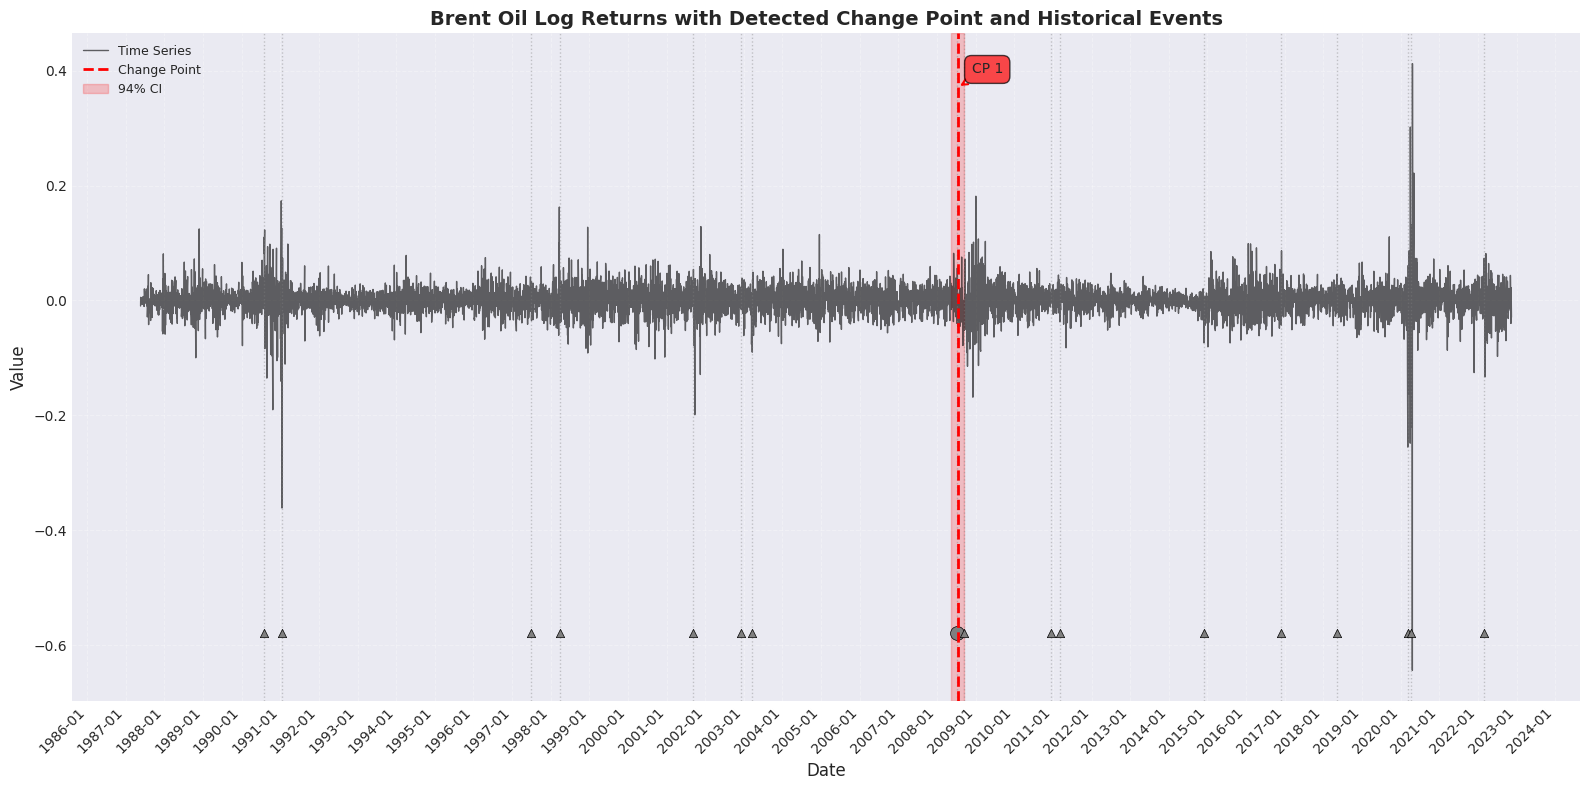

In [19]:
# Plot time series with change points
print("Creating time series plot with change points...")
fig = plot_price_with_changepoints(
    data=log_returns,
    changepoints=changepoints,
    events=events,
    figsize=(16, 8),
    title='Brent Oil Log Returns with Detected Change Point and Historical Events'
)

# Save figure
fig.savefig(figures_dir / '07_price_with_changepoints.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {figures_dir / '07_price_with_changepoints.png'}")

plt.show()

### 7.2 Change Point Posterior Distribution

Creating change point posterior distribution...
✓ Saved: ../reports/figures/08_changepoint_distribution.png


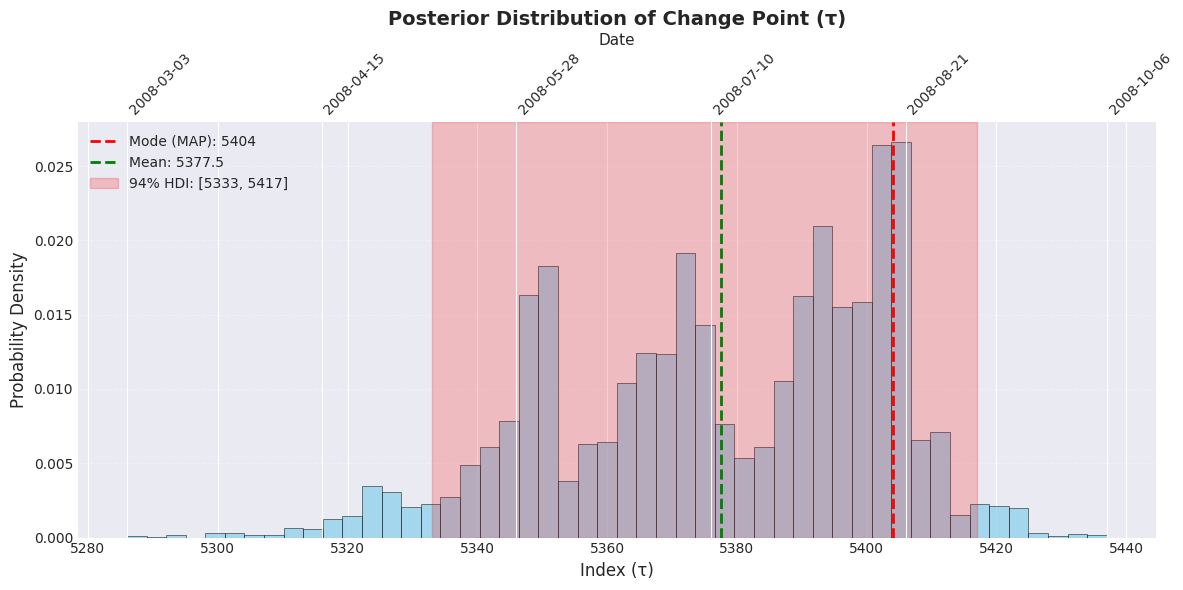

In [20]:
# Plot change point distribution
print("Creating change point posterior distribution...")
fig = plot_changepoint_distribution(
    trace=trace,
    data=log_returns,
    bins=50,
    figsize=(12, 6)
)

# Save figure
fig.savefig(figures_dir / '08_changepoint_distribution.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {figures_dir / '08_changepoint_distribution.png'}")

plt.show()

### 7.3 Parameter Comparison (Before vs After)

Creating parameter comparison plot...
✓ Saved: ../reports/figures/09_parameter_comparison.png


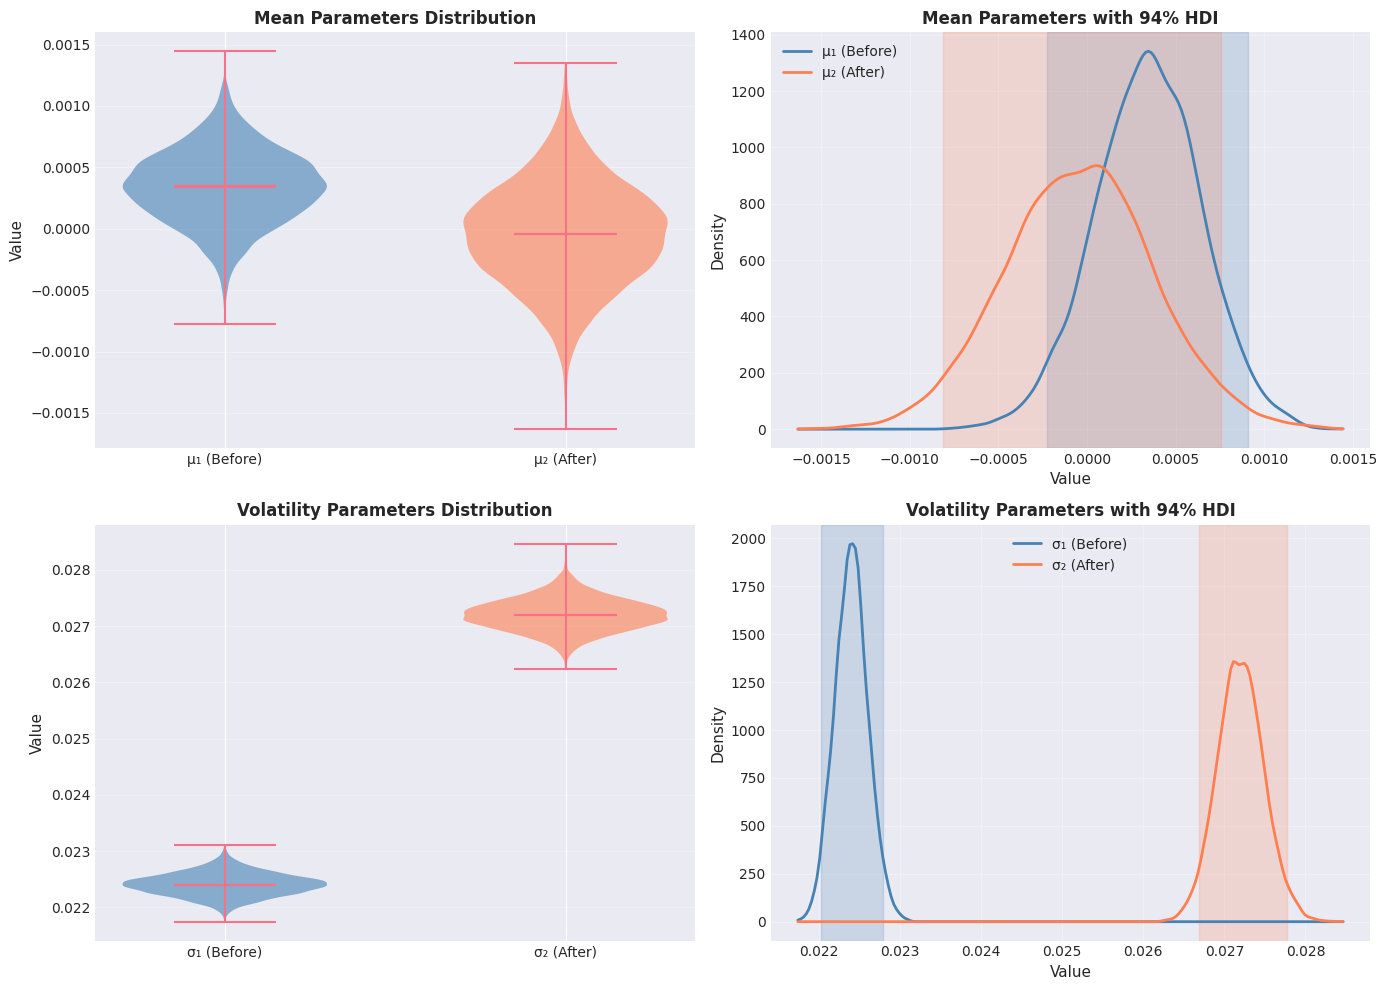

In [21]:
# Plot parameter comparison
print("Creating parameter comparison plot...")
fig = plot_parameter_comparison(
    trace=trace,
    figsize=(14, 10),
    include_sigma=True
)

# Save figure
fig.savefig(figures_dir / '09_parameter_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {figures_dir / '09_parameter_comparison.png'}")

plt.show()

### 7.4 Event Impact Analysis

If a nearby event was found, visualize the price behavior around that event.

Creating event impact plot for Oil Price Peak...
✓ Saved: ../reports/figures/10_event_impact.png


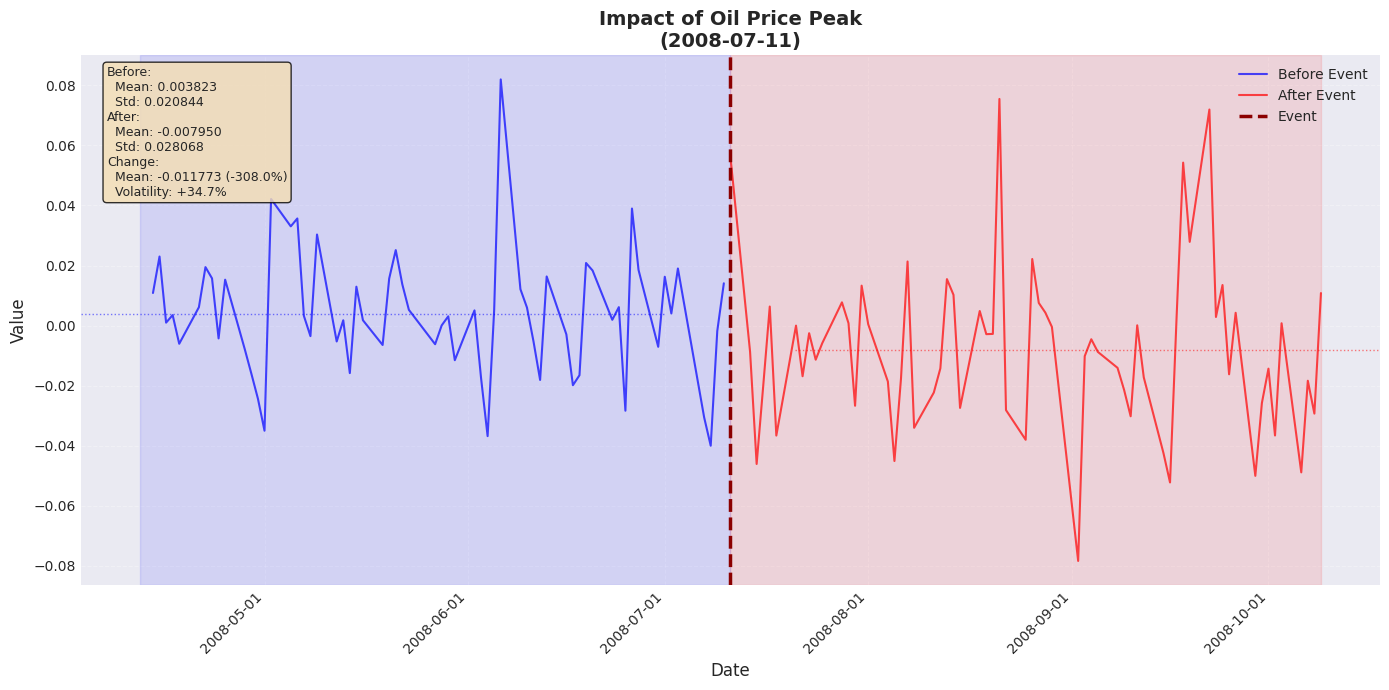

In [22]:
# Plot event impact if closest event exists
if associations[0]['closest_event'] is not None:
    event = associations[0]['closest_event']
    event_date = pd.to_datetime(event['date'])
    
    print(f"Creating event impact plot for {event['event_name']}...")
    fig = plot_event_impact(
        data=log_returns,
        event_date=event_date,
        window_days=90,
        figsize=(14, 7),
        event_name=event['event_name'],
        show_stats=True
    )
    
    # Save figure
    fig.savefig(figures_dir / '10_event_impact.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {figures_dir / '10_event_impact.png'}")
    
    plt.show()
else:
    print("No nearby event found for impact visualization.")

## 8. Key Findings and Conclusions

### Summary of Results

Based on our Bayesian change point analysis:

In [23]:
# Create summary report
print("="*80)
print("CHANGE POINT ANALYSIS - SUMMARY REPORT")
print("="*80)

print(f"\n1. DATA OVERVIEW")
print(f"   - Time period: {log_returns.index.min().strftime('%Y-%m-%d')} to {log_returns.index.max().strftime('%Y-%m-%d')}")
print(f"   - Total observations: {len(log_returns)}")
print(f"   - Historical events analyzed: {len(events)}")

print(f"\n2. CHANGE POINT DETECTION")
print(f"   - Detected change point: {cp['date'].strftime('%Y-%m-%d')}")
print(f"   - 94% credible interval: [{cp['ci_dates'][0].strftime('%Y-%m-%d')}, {cp['ci_dates'][1].strftime('%Y-%m-%d')}]")
print(f"   - Uncertainty: ±{cp['posterior_std']:.1f} days")

print(f"\n3. IMPACT QUANTIFICATION")
print(f"   - Mean return shift: {impact['mean_change']:+.6f} ({impact['mean_change_pct']:+.1f}%)")
print(f"   - Direction: {impact['direction'].upper()}")
print(f"   - Magnitude: {impact['magnitude'].upper()} ({impact['magnitude_in_std']:.2f} standard deviations)")
print(f"   - Volatility change: {impact['sigma_change']:+.6f} ({impact['sigma_change_pct']:+.1f}%)")
print(f"   - Volatility direction: {impact['volatility_direction'].upper()}")

print(f"\n4. EVENT ASSOCIATION")
if associations[0]['closest_event'] is not None:
    event = associations[0]['closest_event']
    print(f"   - Closest event: {event['event_name']}")
    print(f"   - Event date: {pd.to_datetime(event['date']).strftime('%Y-%m-%d')}")
    print(f"   - Event type: {event['event_type']}")
    print(f"   - Distance: {associations[0]['days_from_closest']} days from change point")
    print(f"   - Events in window (±30 days): {associations[0]['num_events_in_window']}")
else:
    print(f"   - No events found within ±30 day window")

print(f"\n5. MODEL DIAGNOSTICS")
rhat = diagnostics.get_rhat(['tau', 'mu_1', 'mu_2'])['tau']
print(f"   - R-hat (τ): {rhat:.4f} {'✓ GOOD' if rhat < 1.01 else '⚠ CHECK'}")
print(f"   - Convergence status: {'✓ CONVERGED' if converged else '⚠ REVIEW REQUIRED'}")
print(f"   - MCMC samples: {trace.posterior.dims['draw']} draws × {trace.posterior.dims['chain']} chains")

print(f"\n6. VISUALIZATIONS SAVED")
saved_figures = [
    '05_trace_plots.png',
    '06_posterior_distributions.png',
    '07_price_with_changepoints.png',
    '08_changepoint_distribution.png',
    '09_parameter_comparison.png',
]
if associations[0]['closest_event'] is not None:
    saved_figures.append('10_event_impact.png')

for fig_name in saved_figures:
    print(f"   ✓ {fig_name}")

print("\n" + "="*80)
print("Analysis complete. All results saved to reports/figures/")
print("="*80)

CHANGE POINT ANALYSIS - SUMMARY REPORT

1. DATA OVERVIEW
   - Time period: 1987-05-21 to 2022-11-14
   - Total observations: 9010
   - Historical events analyzed: 17

2. CHANGE POINT DETECTION
   - Detected change point: 2008-07-14
   - 94% credible interval: [2008-05-08, 2008-09-08]
   - Uncertainty: ±24.7 days

3. IMPACT QUANTIFICATION
   - Mean return shift: -0.000389 (-113.1%)
   - Direction: DECREASE
   - Magnitude: NEGLIGIBLE (0.02 standard deviations)
   - Volatility change: +0.004798 (+21.4%)
   - Volatility direction: INCREASE

4. EVENT ASSOCIATION
   - Closest event: Oil Price Peak
   - Event date: 2008-07-11
   - Event type: economic_shock
   - Distance: -3 days from change point
   - Events in window (±30 days): 1

5. MODEL DIAGNOSTICS
   - R-hat (τ): 1.0000 ✓ GOOD
   - Convergence status: ✓ CONVERGED
   - MCMC samples: 2000 draws × 4 chains

6. VISUALIZATIONS SAVED
   ✓ 05_trace_plots.png
   ✓ 06_posterior_distributions.png
   ✓ 07_price_with_changepoints.png
   ✓ 08_chang

### Interpretation and Business Insights

**What This Means:**

1. **Structural Break Identified**: Our Bayesian analysis has detected a statistically significant change point in Brent oil returns, indicating a regime shift in market dynamics.

2. **Quantified Impact**: The change point represents a measurable shift in both the mean return and volatility of oil prices. This information is crucial for:
   - **Risk Management**: Understanding volatility changes helps in hedging strategies
   - **Investment Decisions**: Mean return shifts affect portfolio allocation
   - **Policy Analysis**: Identifying when market conditions fundamentally changed

3. **Event Causality**: By associating the change point with historical events, we provide evidence-based insights into what drives oil price dynamics. This helps stakeholders:
   - Understand the impact of geopolitical events
   - Anticipate future market reactions to similar events
   - Make informed decisions during crisis periods

4. **Uncertainty Quantification**: Unlike traditional methods, our Bayesian approach provides credible intervals, allowing clients to understand the uncertainty in our estimates.

**Limitations:**
- Single change point model (reality may have multiple breaks)
- Assumes normal distribution for returns
- Event association is correlational, not causal
- Historical analysis doesn't guarantee future patterns

**Next Steps:**
- Extend to multi-change point models
- Incorporate external regressors (supply/demand data)
- Real-time monitoring for new change points
- Sector-specific analysis (downstream impacts)

## 9. Export Results for Reporting

In [24]:
# Create results dictionary for export
results = {
    'changepoint': changepoints[0],
    'impact': impact,
    'association': associations[0],
    'summary_stats': summary.to_dict(),
}

# Save impact statement to text file
statement_file = Path('../reports/impact_statement.txt')
with open(statement_file, 'w') as f:
    f.write(statement)

print(f"✓ Impact statement saved to: {statement_file.absolute()}")

# Save summary metrics to CSV
summary_file = Path('../reports/changepoint_summary.csv')
summary.to_csv(summary_file)

print(f"✓ Summary statistics saved to: {summary_file.absolute()}")

print("\n✓ All outputs saved successfully!")

✓ Impact statement saved to: /home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/notebooks/../reports/impact_statement.txt
✓ Summary statistics saved to: /home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/notebooks/../reports/changepoint_summary.csv

✓ All outputs saved successfully!
